## Estimating Delivery Times
**GOALS: **
1. Predict total delivery duration in seconds: created_at to actual_delivery_time
TODO:
- [ ] EDA
- [ ] Preprocess
- [ ] XGBoost Model
- [ ] TensorFlow ANN

NOTES:
- Feature engineering encouraged

### EDA
- [ ] Graph Relavent Trends
- [ ] Identify key variables

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import datetime as dt

In [2]:
# Parse dates seems to be acting strangely
data = pd.read_csv('../input/doordash-deliveries/historical_data.csv')
data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


In [3]:
#from pandas.plotting import scatter_matrix
#scat_plot = scatter_matrix(data[['subtotal','min_item_price','max_item_price',
#                     'estimated_order_place_duration', 'estimated_store_to_consumer_driving_duration',
#                     'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders']],
#               figsize=(15,12))
#plt.savefig('scatter_matrix.png')

In [4]:
numeric = data[['subtotal','min_item_price','max_item_price',
                     'estimated_order_place_duration', 'estimated_store_to_consumer_driving_duration',
                     'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders']]
corr = numeric.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  """


,subtotal,min_item_price,max_item_price,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_onshift_dashers,total_busy_dashers,total_outstanding_orders
subtotal,1.00,0.04,0.51,0.04,0.03,0.13,0.13,0.13
min_item_price,0.04,1.00,0.55,0.05,0.00,0.04,0.04,0.04
max_item_price,0.51,0.55,1.00,0.09,0.03,0.13,0.13,0.13
estimated_order_place_duration,0.04,0.05,0.09,1.00,-0.02,-0.19,-0.19,-0.17
estimated_store_to_consumer_driving_duration,0.03,0.00,0.03,-0.02,1.00,0.05,0.04,0.04
total_onshift_dashers,0.13,0.04,0.13,-0.19,0.05,1.00,0.94,0.94
total_busy_dashers,0.13,0.04,0.13,-0.19,0.04,0.94,1.00,0.93
total_outstanding_orders,0.13,0.04,0.13,-0.17,0.04,0.94,0.93,1.00


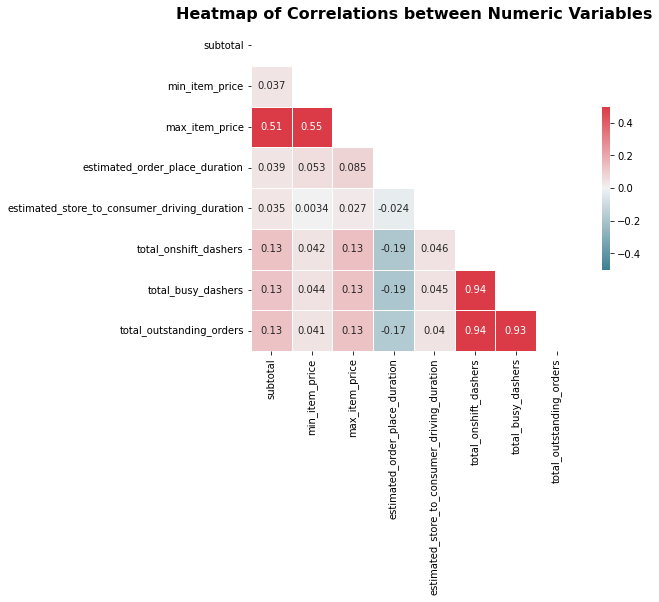

In [5]:
# Create nicer lower triangular seaborn correlation heatmap. Use diverging color palette to get -1,0,1
fig, ax = plt.subplots(figsize=(9,6))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(220,10,as_cmap=True)
sns.heatmap(corr, # Data
            mask=mask, # Mask certain cells
            cmap=cmap, # Colormap
            square=True, # Make squares
            annot=True, # Show values
            vmax=0.5, # Set scale for colors (all above will have same)
            vmin=-0.5, # Min scale
            center=0, # Force center which is white for diverging palette
            linewidths=0.5, # Width of line between squares
            cbar_kws={'shrink':0.5}) # Size of legend
plt.title('Heatmap of Correlations between Numeric Variables', fontweight='bold',fontsize=16)
plt.savefig('correlation_heatmap.png')

### Notes on the Correlations Matrix
- Min and max item price appear very correlated. Can combine into price range of order
- Total busy dashers, total outstanding dashers and total onshift dashers all highly correlated. May be best
- to combine into 1 feature.
- Estimated_order_place_duration sppears to be borderline categorical falling mostly in a few categories
- Some negative correlation between total onshift dashwers, busy dashers, orders and estimated order place duration

In [6]:
data.describe()

,market_id,store_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
count,196441.000000,197428.000000,196433.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,181166.000000,181166.000000,181166.000000,197428.000000,196902.000000
mean,2.978706,3530.510272,2.882352,3.196391,2682.331402,2.670791,686.218470,1159.588630,44.808093,41.739747,58.050065,308.560179,545.358935
std,1.524867,2053.496711,1.503771,2.666546,1823.093688,1.630255,522.038648,558.411377,34.526783,32.145733,52.661830,90.139653,219.352902
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000,0.000000
25%,2.000000,1686.000000,1.000000,2.000000,1400.000000,1.000000,299.000000,800.000000,17.000000,15.000000,17.000000,251.000000,382.000000
50%,3.000000,3592.000000,3.000000,3.000000,2200.000000,2.000000,595.000000,1095.000000,37.000000,34.000000,41.000000,251.000000,544.000000
75%,4.000000,5299.000000,4.000000,4.000000,3395.000000,3.000000,949.000000,1395.000000,65.000000,62.000000,85.000000,446.000000,702.000000
max,6.000000,6987.000000,7.000000,411.000000,27100.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,2715.000000,2088.000000


In [7]:
print(len(data.store_id.unique()))

6743


#### Preliminary Thoughts on Data
- May need some numerical scaling/regularizing on large/small numeric values, we'll see how things turn out
- **Numerical**:
    - [x] Create target column by getting number of seconds from created at to actual delivery time
    - [x] Combine estimated times to get total estimation of order (order place duration + store to consumer)
    - Store_id, which has 6743 unique values
    - Combine estimated categories to get total_order_lag_time
    - Find ratio of total_busy_dashers/total_onshift_dashers = % busy within 10 miles
    - Measure demand level with 
    - Try using PCA to see how many features we really need to explain 70-80% of variance (https://stats.oarc.ucla.edu/spss/seminars/efa-spss/#:~:text=Some%20criteria%20say%20that%20the,only%2050%25%20to%2060%25.) 
    - Also could train random forest and check feature importance then drop those features. Need to  look at highly correlated features and drop.
    
- **Categorical**:
    - store_primary_category - 75 unique categories. Cardinality is too high here for good one-hot. Maybe more succient categories. For example, combine csuisines, alcohol and alchohol+food and gastro pub, convenience store, breakfast, chocolate, cheese, smoothie
    - [x]  store_primary_category also has 4770 nan values, 2.41% of the total entries. These can be imputed with the most common category at each store.
    - [x] order_protocol - 1-7 with nan
    - [x] market_id is also categorical variable with values 1-6
- For store 

### Numerical Data Preprocessing

In [8]:
# Create target, the delivery time in seconds: delivery time - created at
# Use to_datetime method since parse_dates had difficulty. Target has order of 10^6 seconds. Doesn't make sense
data.created_at = pd.to_datetime(data.created_at)
data.actual_delivery_time = pd.to_datetime(data.actual_delivery_time)
data['target'] = (data.actual_delivery_time - data.created_at).dt.total_seconds()

# Get estimated delivery time combining estimated columns
data['estimated_target'] = (data.estimated_order_place_duration + data.estimated_store_to_consumer_driving_duration)
data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,target,estimated_target
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0,1307.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,1136.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0,1136.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0,735.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0,1096.0


NOTE: The sorted table above clearly contains at least 1 massive outlier at index 2690. Simply remove it.

In [9]:
data.sort_values(by='target', ascending=False).head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,target,estimated_target
2690,1.0,2014-10-19 05:24:15,2015-01-25 19:11:54,3560,italian,1.0,1,1695,1,1595,1595,NaN,NaN,NaN,446,412.0,8516859.0,858.0
185550,4.0,2015-01-28 08:34:06,2015-02-01 16:25:25,6503,dessert,5.0,3,1520,3,220,750,0.0,0.0,0.0,251,476.0,373879.0,727.0
27189,1.0,2015-02-16 02:24:09,2015-02-19 22:45:31,4338,indian,3.0,4,4980,4,995,1795,72.0,68.0,104.0,251,767.0,332482.0,1018.0
83055,2.0,2015-02-01 02:18:07,2015-02-01 18:08:39,355,burger,4.0,3,2379,2,389,695,109.0,102.0,163.0,251,602.0,57032.0,853.0
190860,1.0,2015-02-16 02:31:05,2015-02-16 17:38:32,2169,indian,3.0,4,3660,4,375,1195,71.0,70.0,111.0,251,326.0,54447.0,577.0


### Categorical Data Preprocessing

In [10]:
# Transforming order_protocol to one-hot encoding -- 1 feature --> 7 features
cat_order_protocol = pd.get_dummies(data.order_protocol)
cat_order_protocol = cat_order_protocol.add_prefix('order_protocol_')
cat_order_protocol.head()

,order_protocol_1.0,order_protocol_2.0,order_protocol_3.0,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0
0,1,0,0,0,0,0,0
1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0


In [11]:
# Transforming market_id to one-hot encoding -- 1 features --> 6 features
cat_market_id = pd.get_dummies(data.market_id)
cat_market_id = cat_market_id.add_prefix('market_id_')
cat_market_id.head()

,market_id_1.0,market_id_2.0,market_id_3.0,market_id_4.0,market_id_5.0,market_id_6.0
0,1,0,0,0,0,0
1,0,1,0,0,0,0
2,0,0,1,0,0,0
3,0,0,1,0,0,0
4,0,0,1,0,0,0


Text(0.5, 1.0, 'Count of Primary Categories')

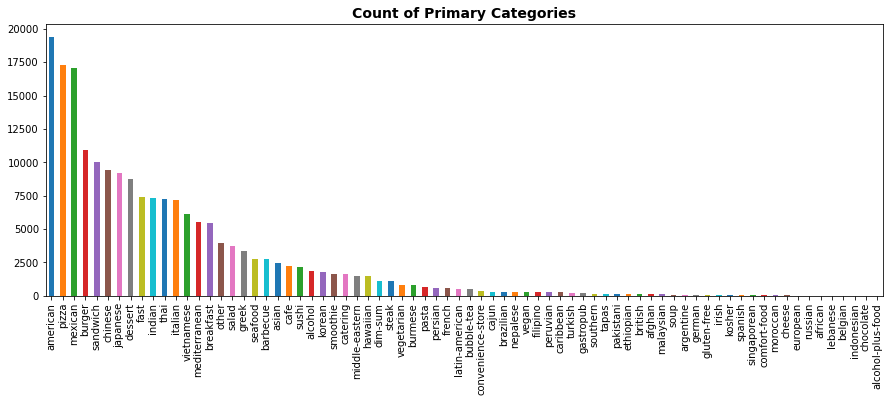

In [12]:
# Percent of stores with no labeled category = 2.41%
sum(data.store_primary_category.isna())/len(data)
# We can impute these values with the most common entry. First figure out the counts of each category
cmap = mpl.colormaps['tab10']
fig = data.store_primary_category.value_counts().plot(kind='bar',figsize=(15,5),color=cmap.colors)
fig.set_title('Count of Primary Categories',fontweight='bold',fontsize=14)

**Filling nan category values**
- For reach individual store, get the most common product category and fill nan values with that
- Use the mode function for each store id.

In [13]:
# The most common primary category is american with nearly 20k entries. For each store (by store id)
# get the most common category of product from each store. Fill nan values with that value.
store_ids = data["store_id"].unique().tolist()
category_modes = {}
for the_id in store_ids:
    category_modes[the_id] = data[data.store_id == the_id].store_primary_category.mode()

In [14]:
# How to access the mode of the categories for each store number. Need to get 0th element of dict
category_modes[data['store_id'][0]][0]

'american'

In [15]:
# Fill all nan categories with the mode of the categories of that store id
data['cat_categories_filled'] = pd.DataFrame(data['store_primary_category'].fillna(category_modes[data['store_id'][0]].values[0]))
len(data.cat_categories_filled.unique())

74

In [16]:
# Transforming primary_category to one-hot encoding -- 1 features --> 74 features
cat_primary_cat= pd.get_dummies(data.cat_categories_filled)
cat_primary_cat.head()

,afghan,african,alcohol,alcohol-plus-food,american,argentine,asian,barbecue,belgian,brazilian,...,southern,spanish,steak,sushi,tapas,thai,turkish,vegan,vegetarian,vietnamese
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Feature Selection
- [ ] Re-combine numeric and categorical and ordinal features
- [ ] Look for highly correlated features
- [ ] Reduce with some calculated features
- [ ] Use PCA to help reduce space
- [ ] Select features by checking feature importance with Random Forest

In [17]:
# Recombine categoriecal, numerical, and ordinal features.
df_comb = pd.concat([data, cat_market_id, cat_order_protocol, cat_primary_cat], axis=1)
df_comb.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,...,southern,spanish,steak,sushi,tapas,thai,turkish,vegan,vegetarian,vietnamese
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,...,0,0,0,0,0,0,0,0,0,0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,...,0,0,0,0,0,0,0,0,0,0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,...,0,0,0,0,0,0,0,0,0,0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,...,0,0,0,0,0,0,0,0,0,0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,...,0,0,0,0,0,0,0,0,0,0


### Aside: Anomaly Detection using PCA/Guassian Mixture
- Huge outliers exist in the target variable. Max is 8.5 million seconds (2361 hours)
    - The following indices are problematic: 2690,185550,27189,83055,190860,86952
    - It was market id 1, where it took over 3 months from an italian store for 1 item at $1595
    - Weirdly, the estimated time was only 412 seconds. This is probably an outlier we should throw out

[(0.0, 20000.0)]

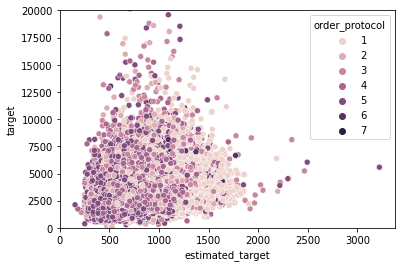

In [18]:
# Look at plot of estimated times vs. actual times, setting y-axis to ignore outliers for now
fig = sns.scatterplot(data=data, x='estimated_target', y='target', hue='order_protocol')
fig.set(ylim=(0,20000))
#fig.set_title('Delivery Time vs. Default Model Time Predictions', fontweight='bold', fontsize='14')
#fig.set_ylim(0,30000)

In [19]:
df_comb.columns

Index(['market_id', 'created_at', 'actual_delivery_time', 'store_id',
       'store_primary_category', 'order_protocol', 'total_items', 'subtotal',
       'num_distinct_items', 'min_item_price',
       ...
       'southern', 'spanish', 'steak', 'sushi', 'tapas', 'thai', 'turkish',
       'vegan', 'vegetarian', 'vietnamese'],
      dtype='object', length=106)

In [20]:
from sklearn.mixture import BayesianGaussianMixture
numeric = df_comb[['target','estimated_target','subtotal','max_item_price']].dropna()
bgm = BayesianGaussianMixture(n_components = 5, n_init=10)
bgm.fit(numeric)

/opt/conda/lib/python3.7/site-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,


BayesianGaussianMixture(n_components=5, n_init=10)

In [21]:
densities = bgm.score_samples(numeric)
density_threshold = np.percentile(densities,4)
anomalies = numeric[densities < density_threshold]
anomalies.sort_values(by='target',ascending=False)
anomalies.describe()

,target,estimated_target,subtotal,max_item_price
count,7.876000e+03,7876.000000,7876.000000,7876.000000
mean,5.813589e+03,920.960767,5886.254952,2101.220543
std,9.611617e+04,345.796374,3637.221393,1279.902710
min,2.230000e+02,182.000000,0.000000,0.000000
25%,2.888500e+03,637.000000,2975.000000,1195.000000
50%,4.228000e+03,914.000000,5000.000000,1889.000000
75%,5.708000e+03,1173.000000,8667.500000,2860.000000
max,8.516859e+06,3222.000000,27100.000000,14700.000000


In [22]:
# Create new dataframe where we remove anomalies
drop_list = anomalies.index
df_comb_no_anomaly = df_comb.drop(index=drop_list)
df_comb_no_anomaly.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,...,southern,spanish,steak,sushi,tapas,thai,turkish,vegan,vegetarian,vietnamese
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,...,0,0,0,0,0,0,0,0,0,0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,...,0,0,0,0,0,0,0,0,0,0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,...,0,0,0,0,0,0,0,0,0,0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,...,0,0,0,0,0,0,0,0,0,0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:title={'center':'target'}, xlabel='market_id'>

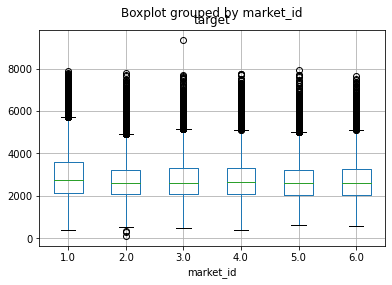

In [23]:
df_comb_no_anomaly.sort_values(by='target', ascending=False).boxplot(column='target', by='market_id')

<AxesSubplot:title={'center':'target'}, xlabel='market_id'>

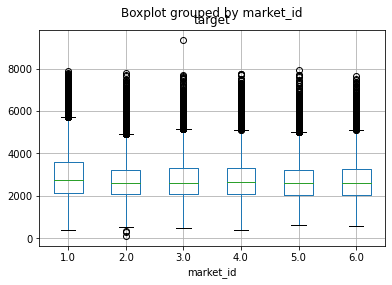

In [24]:
# Plot target variable distribution for each value of market id
#fig, (ax1, ax2)= plt.subplots(1,2)
df_comb_no_anomaly.sort_values(by='target', ascending=False).boxplot(column='target', by='market_id')
#ax1 = sns.boxplot(data=df_comb_no_anomaly,y='target',x='market_id')
#plt.title('Order Time for Each Market ID', fontweight='bold', fontsize=14)

<AxesSubplot:xlabel='market_id', ylabel='target'>

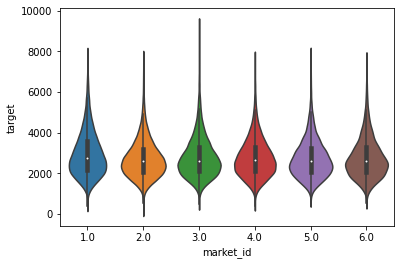

In [25]:
sns.violinplot(data=df_comb_no_anomaly,y='target',x='market_id')

<AxesSubplot:xlabel='order_protocol', ylabel='target'>

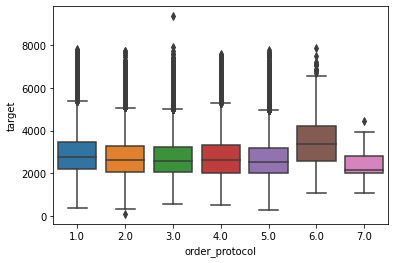

In [26]:
# Plot target variable distribution for each value of order protocol
sns.boxplot(data=df_comb_no_anomaly, x='order_protocol', y='target')

<AxesSubplot:xlabel='order_protocol', ylabel='target'>

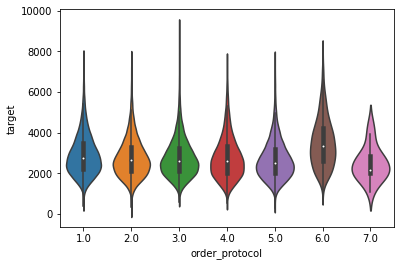

In [27]:
sns.violinplot(data=df_comb_no_anomaly, x='order_protocol', y='target')

In [28]:
df_comb.columns

Index(['market_id', 'created_at', 'actual_delivery_time', 'store_id',
       'store_primary_category', 'order_protocol', 'total_items', 'subtotal',
       'num_distinct_items', 'min_item_price',
       ...
       'southern', 'spanish', 'steak', 'sushi', 'tapas', 'thai', 'turkish',
       'vegan', 'vegetarian', 'vietnamese'],
      dtype='object', length=106)

In [29]:
from sklearn.decomposition import PCA
# Identify principal components
numerical = df_comb[['total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 
                         'max_item_price', 'total_onshift_dashers','total_busy_dashers',
                        'total_outstanding_orders', 'estimated_order_place_duration', 
                         'estimated_target']]
# TEMP: Drop all categorical/ordinal and nan values -- we'll do this again later
df = numerical.dropna()
# Fit PCA and get number of components we need
pca = PCA(random_state = 123)
pca.fit_transform(df)
variances = pca.explained_variance_ratio_.tolist()
print(variances)
print(f'Total Variance Explained by First 5 Components: {round(sum(variances[0:5])*100,2)}%')

[0.8583897629740752, 0.10034672103613164, 0.02431743627463864, 0.014004245944430557, 0.0018353121165891866, 0.001058430271403364, 3.14494040972953e-05, 1.5568070245909696e-05, 9.198955368087789e-07, 1.540128513559976e-07]
Total Variance Explained by First 5 Components: 99.89%


In [30]:
# Scale data to prepare to do anomaly detection
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_features, index=df.index,columns=df.columns)
scaled_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_target
0,0.295935,0.405632,0.812248,-0.245299,0.138783,-0.342255,-0.863092,-0.703711,1.517694,1.926808
1,-0.826300,-0.436938,-1.031180,1.371935,0.425319,-1.268671,-1.236236,-1.064352,1.517694,1.198116
2,-0.826300,-0.436938,-1.031180,2.331148,1.315184,-1.268671,-1.298427,-1.102314,1.517694,1.198116
3,1.044092,2.296906,1.426724,-0.162807,1.137211,-1.268671,-1.267331,-1.064352,1.517694,-0.510688
4,-0.078143,0.656599,0.197772,0.796407,0.781265,-1.123918,-1.111855,-0.931484,1.517694,1.027662


In [31]:
pca = PCA(n_components=5, random_state=123)
df_pca = pd.DataFrame(pca.fit_transform(scaled_df), index=scaled_df.index)
df_restored = pd.DataFrame(pca.inverse_transform(df_pca), index=df_pca.index)
print(f'Variance Explained by PCs = : {pca.explained_variance_ratio_}')
print(f'Sum of Variance Explained by PCs = {round(sum(pca.explained_variance_ratio_.tolist())*100,2)}%')

Variance Explained by PCs = : [0.30552209 0.24332971 0.1766256  0.12579678 0.06172792]
Sum of Variance Explained by PCs = 91.3%


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  


Text(0.5, 1.0, 'Percent of Variance Explained')

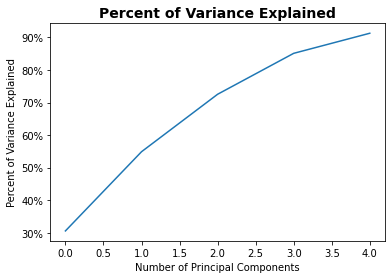

In [32]:
# Plot Cumulative Expected Value vs. Number of Components
ax = sns.lineplot(data=np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Principal Components')
plt.ylabel('Percent of Variance Explained')
yvals = ax.get_yticks()
ax.set_yticklabels([f'{round(y*100)}%' for y in yvals])
#plt.set_yticks()
plt.title('Percent of Variance Explained', fontweight='bold',fontsize=14)

In [33]:
# Create function to calculate/plot loss from PCA reconstruction using sum of squared residuals
from sklearn.metrics import mean_squared_error
def pca_reconstruction_loss(df, df_restored):
    reconstruction_loss = np.sum((np.array(df) - np.array(df_restored)) ** 2, axis=1)
    reconstruction_loss = pd.Series(data=reconstruction_loss, index=df.index)
    return reconstruction_loss

def id_anomaly(data, pca, threshold):
    pca_data = pca.transform(data)
    restored_data = pca.inverse_transform(pca_data)
    loss = np.sum((data - restored_data) ** 2)
    return loss > threshold

In [34]:
# Find the reconstruction error to identify outliers
reconstruction_errors = pca_reconstruction_loss(scaled_df, df_restored)

Text(0, 0.5, 'Squared Error Between Transformed and Inverse Transform')

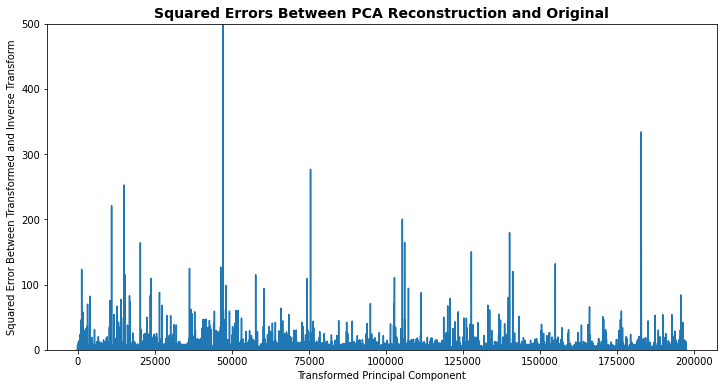

In [35]:
# Plot the squared residual "errors" and we'll see errors identified by PCA
plt.figure(figsize=(12,6))
fig = sns.lineplot(data=reconstruction_errors)
plt.title('Squared Errors Between PCA Reconstruction and Original',fontsize=14,fontweight='bold')
plt.ylim(0,500)
plt.xlabel('Transformed Principal Component')
plt.ylabel('Squared Error Between Transformed and Inverse Transform')

### Note:
- There are ~197k data points. It seems pretty clear that most are small errors. I suppose it will be a judgement call, but let's eliminate points with squared error above 50, 

In [36]:
reconstruction_df = pd.DataFrame(reconstruction_errors, index=scaled_df.index, columns=['Reconstruction Error'])
#reconstruction_df.head()
reconstruction_df[reconstruction_df['Reconstruction Error'] > 50].head()

,Reconstruction Error
1346,52.475459
1351,84.694572
1353,123.084235
1828,57.669137
3260,69.905483


In [37]:
reconstruction_df.sort_values(by='Reconstruction Error', ascending=False)

,Reconstruction Error
47231,15480.452521
182800,333.996307
182796,331.394903
75577,276.663310
15053,252.569290
...,...
192067,0.002095
57115,0.001986
179956,0.001576
8038,0.001415


In [38]:
# Go back to original data with constructed feature and look at individual outliers you identified
df_comb.iloc[[47231],:]

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,...,southern,spanish,steak,sushi,tapas,thai,turkish,vegan,vegetarian,vietnamese
47231,2.0,2015-02-06 00:42:39,2015-02-06 01:33:34,777,fast,4.0,411,3115,5,0,...,0,0,0,0,0,0,0,0,0,0


## NOTE TODO
- Doing a prediction of the prep time and a separate regression for the total delivery time appears to have better results
- Categorical variables don't appear to matter, show this using an RF and feature importance. 
- Use MSE to look at loss/differences since it's less sensitive to outliers. Consider throwing away some of these outliers. Q: How do you get identify and get rid of them in the above?

### Continuing Feature Selection with Random Forest
#### NOTE: We will continue starting after the gaussian mixture outlier removal
- df_comb_no_anomaly is a df containing all of the input data with our calculated target and estimated target
- We will proceed with the outlier removal via BGM rather than PCA, as it seemed sufficient.

### RENAMING df_comb_no_anomaly --> df

In [39]:
df = df_comb_no_anomaly.copy()
df.columns

Index(['market_id', 'created_at', 'actual_delivery_time', 'store_id',
       'store_primary_category', 'order_protocol', 'total_items', 'subtotal',
       'num_distinct_items', 'min_item_price',
       ...
       'southern', 'spanish', 'steak', 'sushi', 'tapas', 'thai', 'turkish',
       'vegan', 'vegetarian', 'vietnamese'],
      dtype='object', length=106)

### Calculated Features
- A few of our features were so highly correlated they should be combined by hand
- Recall that 
    - data['target'] = (data.actual_delivery_time - data.created_at).dt.total_seconds()
    - data['estimated_target'] = (data.estimated_order_place_duration + data.estimated_store_to_consumer_driving_duration)

In [40]:
# Calculate range of item prices
df['price_range'] = df['max_item_price'] - df['min_item_price']
# Calculate ratio of busy dashers
df['busy_dasher_ratio'] = df['total_busy_dashers']/df['total_onshift_dashers']
# Calculate ratio of distinct items over total items
df['percent_unique'] = df['num_distinct_items']/df['total_items']
# Get Average Price per item from subtotal
df['avg_price_per_item'] = df['subtotal']/df['total_items']

(array([5.55360e+04, 1.06724e+05, 2.28510e+04, 3.36600e+03, 9.04000e+02,
        1.32000e+02, 2.10000e+01, 1.30000e+01, 4.00000e+00, 1.00000e+00]),
 array([   0. ,  688.9, 1377.8, 2066.7, 2755.6, 3444.5, 4133.4, 4822.3,
        5511.2, 6200.1, 6889. ]),
 <BarContainer object of 10 artists>)

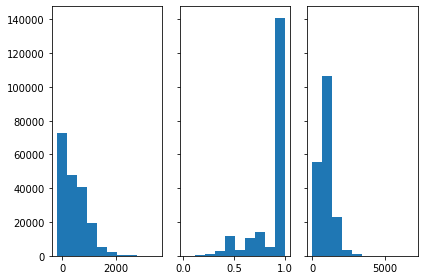

In [41]:
fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True)
axs[0].hist(df['price_range'])
axs[1].hist(df['percent_unique'])
axs[2].hist(df['avg_price_per_item'])

/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


<AxesSubplot:ylabel='busy_dasher_ratio'>

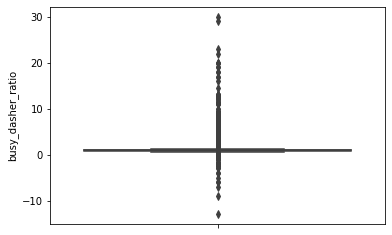

In [42]:
sns.boxplot(data=df,y='busy_dasher_ratio')

#### Notes on New Columns
- price range has 0 and negative values. Replace those with median?
- busy dasher ratio has infinite and 0 values. Replace with median


In [43]:
# Handling busy_dasher_ratio infinite and null values
df.busy_dasher_ratio.replace([np.inf, -np.inf], np.nan, inplace=True) # Replace infinite with nan
# Drop these null rows
df.dropna(inplace=True)

In [44]:
# Check for remaining infinite values
np.where(np.any(~np.isfinite(df[['price_range','busy_dasher_ratio','percent_unique',
                                 'avg_price_per_item']]),axis=0) == True)

(array([], dtype=int64),)

In [45]:
df.columns

Index(['market_id', 'created_at', 'actual_delivery_time', 'store_id',
       'store_primary_category', 'order_protocol', 'total_items', 'subtotal',
       'num_distinct_items', 'min_item_price',
       ...
       'tapas', 'thai', 'turkish', 'vegan', 'vegetarian', 'vietnamese',
       'price_range', 'busy_dasher_ratio', 'percent_unique',
       'avg_price_per_item'],
      dtype='object', length=110)

NOTE: ADD cat_categories_filled back in after re compiling everything. We need to show that the feature importances are very low
- Also need to look at store id's and see if data differ signifcantly

In [46]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X_fs = df.drop(['target','created_at','actual_delivery_time', 'store_id','store_primary_category',
            'min_item_price', 'max_item_price','total_items','subtotal', 'num_distinct_items',
            'total_busy_dashers','total_onshift_dashers', 'cat_categories_filled','market_id',
               'order_protocol'], axis=1)
#X = df[['estimated_target','busy_dasher_ratio', 'percent_unique', 'avg_price_per_item']]
y_fs = df['target']
X_fs.head()

,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,estimated_target,market_id_1.0,market_id_2.0,market_id_3.0,market_id_4.0,market_id_5.0,market_id_6.0,...,tapas,thai,turkish,vegan,vegetarian,vietnamese,price_range,busy_dasher_ratio,percent_unique,avg_price_per_item
0,21.0,446,861.0,1307.0,1,0,0,0,0,0,...,0,0,0,0,0,0,682,0.424242,1.00,860.25
1,2.0,446,690.0,1136.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,2.000000,1.00,1900.00
8,18.0,446,289.0,735.0,0,1,0,0,0,0,...,0,0,0,0,0,0,784,0.750000,0.75,1192.75
14,8.0,446,795.0,1241.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1.200000,1.00,1525.00
15,7.0,446,205.0,651.0,1,0,0,0,0,0,...,0,0,0,0,0,0,770,1.000000,1.00,1810.00


In [47]:
X_train_fs, X_test_fs, y_train_fs, y_test_fs = train_test_split(X_fs,y_fs,test_size=0.2,random_state=123)

rf = RandomForestRegressor(random_state=123)
rf.fit(X_train_fs,y_train_fs)

RandomForestRegressor(random_state=123)

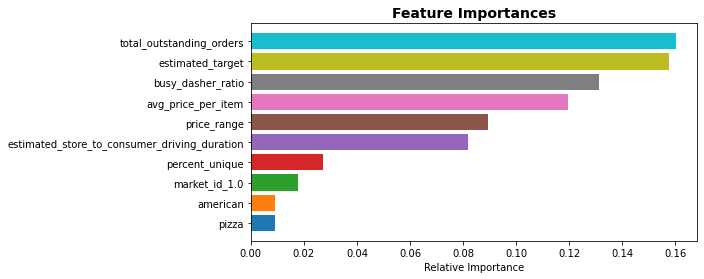

In [48]:
# Look at feature importances
import matplotlib as mpl
def graph_feature_importance(model):
    importances = model.feature_importances_
    indices = np.argsort(importances)[-10:] # Get top 10 most important features
    features = X_train_fs.columns
    f, ax = plt.subplots(figsize=(8, 4))
    plt.title('Feature Importances', fontweight='bold', fontsize=14)
    cmap = mpl.colormaps['tab10']
    plt.barh(range(len(indices)), importances[indices], color = cmap.colors)
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()
graph_feature_importance(rf)

In [49]:
feature_sort = np.sort(rf.feature_importances_)[::-1]
sum(feature_sort[:10])

0.8033333574057031

### NOTE:
- Feature importances show, as backed up by PCA earlier, that total_outstanding orders, estimated target, busy dasher ratio, avg pric per item, price range, estimated driving duration, percent unique,

In [50]:
X = X_fs[['total_outstanding_orders','estimated_target','busy_dasher_ratio','avg_price_per_item',
         'price_range','estimated_store_to_consumer_driving_duration','percent_unique']]
y = y_fs

#X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=123)

In [51]:
X.head()

,total_outstanding_orders,estimated_target,busy_dasher_ratio,avg_price_per_item,price_range,estimated_store_to_consumer_driving_duration,percent_unique
0,21.0,1307.0,0.424242,860.25,682,861.0,1.00
1,2.0,1136.0,2.000000,1900.00,0,690.0,1.00
8,18.0,735.0,0.750000,1192.75,784,289.0,0.75
14,8.0,1241.0,1.200000,1525.00,0,795.0,1.00
15,7.0,651.0,1.000000,1810.00,770,205.0,1.00


## Approach 1: XGBoost
### Step 1: Scaling Numerical Features
    - Having removed outliers, lets just use Standard Scaler

In [52]:
from sklearn.preprocessing import StandardScaler

# Create separate scalers for numeric X features and y target
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=123)

X_scaler_train, X_scaler_test = StandardScaler(), StandardScaler()
X_train_scl, X_test_scl = X_scaler_train.fit_transform(X_train), X_scaler_test.fit_transform(X_test)
X_train_scl = pd.DataFrame(X_train_scl, columns = X_train.columns, index=X_train.index)
X_test_scl = pd.DataFrame(X_test_scl, columns = X_test.columns, index=X_test.index)
X_train_scl.head()

,total_outstanding_orders,estimated_target,busy_dasher_ratio,avg_price_per_item,price_range,estimated_store_to_consumer_driving_duration,percent_unique
60798,-0.195297,0.412991,0.073159,0.271612,1.071615,0.698782,0.532150
175550,-0.157135,1.253529,0.058566,-1.588399,-0.300180,1.594172,-0.583823
48196,-0.824978,0.461147,0.127153,-1.660788,-0.550381,0.750080,0.532150
34437,-1.111197,1.651909,-1.776125,0.613848,-0.116842,1.109169,0.532150
189716,-0.844059,0.640637,0.127153,-0.778673,0.508661,0.031902,0.532150


### Baseline Model: XGBoost

In [53]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

xg_r = xgb.XGBRegressor(seed=123) # Baseline model
xg_r.fit(X_train_scl, y_train)
y_pred = xg_r.predict(X_test_scl)
print(f'RMSE = {mean_squared_error(y_test, y_pred, squared=False)}')

RMSE = 872.3839219248758


So it would seem that our RMSE is roughly 886 or about 14.7 minutes on average.
- May need to tune hyperparameters to make result smaller.
- Need to try other regressors such as linear regression, random forest regressor
- Need to try deep learning approach.

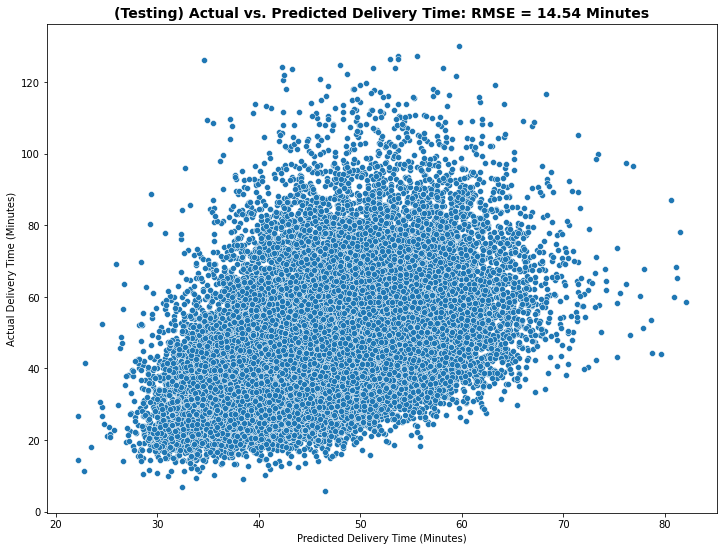

In [54]:
def plot_preds(y_model, y_real):
    f, ax = plt.subplots(figsize=(12, 9))
    sns.scatterplot(x=y_model/60,y=y_real/60)
    plt.title(f'(Testing) Actual vs. Predicted Delivery Time: RMSE = {round(mean_squared_error(y_real, y_model, squared=False)/60,2)} Minutes',
         fontweight='bold', fontsize=14)
    plt.xlabel('Predicted Delivery Time (Minutes)')
    plt.ylabel('Actual Delivery Time (Minutes)')
plot_preds(y_pred,y_test)    

### XGBoost Hyperparameter Tuning
1. First Plot learning curves

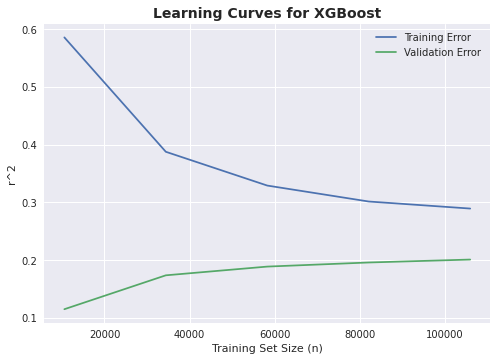

In [55]:
from sklearn.model_selection import learning_curve

# Plot learning curves with default 5-fold CV.
train_sizes, train_scores, validation_scores = learning_curve(xg_r, X_train_scl, y_train)
train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)
plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label='Training Error')
plt.plot(train_sizes, validation_scores_mean, label='Validation Error')
plt.title('Learning Curves for XGBoost', fontweight='bold', fontsize=14)
plt.xlabel('Training Set Size (n)')
plt.ylabel('r^2')
plt.legend()

2. Grid Search over XGBoost parameters: https://xgboost.readthedocs.io/en/stable/parameter.html
    - Eta: The learning rate default 0.3 make smaller to make more conservative. Control over fitting
    - Gamma: Minimum loss reduction to create another leaf default 0
    - Max depth: Increasing will increase complexity. Default 6
    - Lambda: Default 1, L2 regularization term. Increasing makes more conservative
    - Objective: Default is reg:squarederror

In [56]:
from sklearn.model_selection import GridSearchCV
parameters = {'learning_rate': [0.03, 0.3, 0.5],
             'max_depth': [3, 6, 10],
             'lambda': [0.1, 1, 2]}

xgb_grid = GridSearchCV(xg_r, parameters) # Default cv is 5-fold
xgb_grid.fit(X_train_scl, y_train)

GridSearchCV(estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    callbacks=None, colsample_bylevel=1,
                                    colsample_bynode=1, colsample_bytree=1,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=0, gpu_id=-1, grow_policy='depthwise',
                                    importance_type=None,
                                    interaction_constraints='',
                                    learning_rate=0.300000012, max_bin=256,
                                    max_cat_to_onehot=4, max_delta_step=0,
                                    max_depth=6, max_leaves=0,
                                    min_child_weight=1, missing=nan,
                                    monotone_constraints='()', n_estimators=100,
                                    n_jobs=0, num_parallel_tree=1,
   

In [57]:
print(f'Best Score RMSE: {xgb_grid.best_score_}')
print(f'Best Params: {xgb_grid.best_params_}')
print(f'Best Model: {xgb_grid.best_estimator_}')

Best Score RMSE: 0.2025560889527532
Best Params: {'lambda': 0.1, 'learning_rate': 0.3, 'max_depth': 3}
Best Model: XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='', lambda=0.1,
             learning_rate=0.3, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=123,
             reg_alpha=0, ...)


RMSE = 867.6571279614951


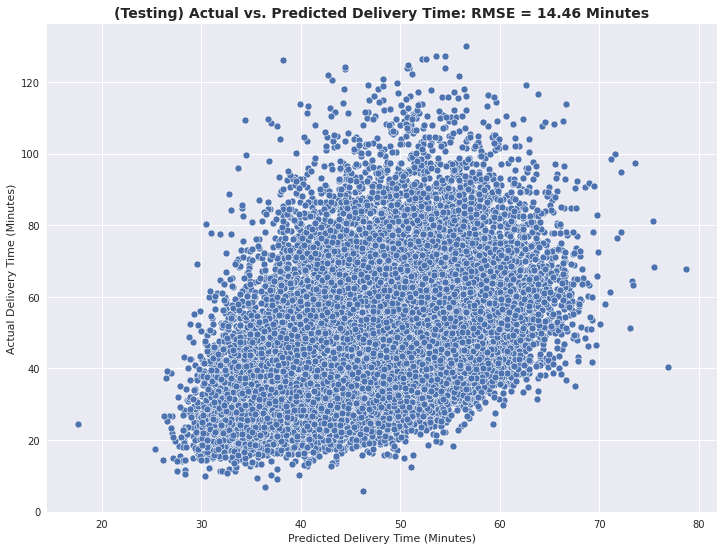

In [58]:
y_pred_best = xgb_grid.best_estimator_.predict(X_test_scl)
print(f'RMSE = {mean_squared_error(y_test, y_pred_best, squared=False)}')
plot_preds(y_pred_best, y_test)

#### Conclusions:
- Grid Search yielded marginally better results when decreasing regularization and decreasing the max depth of the tree

### Trying Other Classical ML Models

In [59]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
models = {
    "LinearRegression" : LinearRegression(), # Standard linear regression no regularizing
    "RidgeRegression" : Ridge(), # Linear Regression with L1 regularizing
    "RandomForest" : RandomForestRegressor(), # Random Forest
    "XGBoost": xgb.XGBRegressor(), # Boosted Decision Tree
}

# Loop over model keys in library of models to compare RMSE's (baseline with no hyperparameter tuning)
ml_results = pd.DataFrame({"Model": [], "RMSE": []})
for model in models.values():
    model.fit(X_train_scl, y_train)
    y_pred_temp = model.predict(X_test_scl)
    print(f'RMSE = {mean_squared_error(y_test, y_pred_temp, squared=False)}')
    new_row = pd.DataFrame({'Model': [model], 'RMSE': [mean_squared_error(y_test, y_pred_temp, squared=False)]})
    ml_results = pd.concat([ml_results,new_row])
    
ml_results    

RMSE = 894.8535175626655
RMSE = 894.8534960851952
RMSE = 889.5338614432577
RMSE = 872.3839219248758


,Model,RMSE
0,LinearRegression(),894.853518
0,Ridge(),894.853496
0,"(DecisionTreeRegressor(max_features='auto', ra...",889.533861
0,"XGBRegressor(base_score=0.5, booster='gbtree',...",872.383922


In [60]:
pd.concat([ml_results,new_row])

,Model,RMSE
0,LinearRegression(),894.853518
0,Ridge(),894.853496
0,"(DecisionTreeRegressor(max_features='auto', ra...",889.533861
0,"XGBRegressor(base_score=0.5, booster='gbtree',...",872.383922
0,"XGBRegressor(base_score=0.5, booster='gbtree',...",872.383922


### Approach 2: TensorFlow Deep Learning